# [Particle aggregation](@id Aggregation)

In this model we are going to make a model with the following properties:

 - Soft spheres with repulsion and adeshion
 - Viscous brownian motion dynamics
 - Particle confinement in a simulation space

## The model

The model will act with viscous brownian motion dynamics of the form:

$$dx_i = \underbrace{\sum_j f(x_i,x_j)}_{\text{deterministic term}} dt + \underbrace{D}_{\text{stochastic term}} dW$$

where the forces of interaction are of the form

$$f(x,y)=\begin{cases}
F_{rep}(r_{rep}-x)\hspace{1cm}\text{if   }||x-y||_2 <= r_{rep}\\
-F_{atr}(r_{atr}-x)\hspace{.75cm}\text{if   }r_{rep} < ||x-y||_2 < r_{at}\\
0\hspace{2.45cm}\text{otherwise   }\\
\end{cases}$$
and some radius of repulsion $r_{rep}$ and attraction $r_{atr}$.

The forces of the particles over the walls will be of the maximum size of repulsion $f_{rep}$.

We are going to create the model step by step with the corresponding tests to check that it works properly.

## Load the package and the plotting functions

In [1]:
using CellBasedModels
using GLMakie
Makie.inline!(true);

## Construct the AgentBasedModel (ABM)

We are going to make the simulations of a model in 2D. By declaring a model with `ABM(2,...)` we are already declaring a model that includes two agent parameters: `x` and `y`. Agent parameters are parameters that have a value for each agent independently. 

If we want to have track of the forces exerted over each particle, we need to define additionally two more agent parameters:

 - `fx`
 - `fy`

Additionally, our model has several global parameters. That is, parameters that are shared among all the agents in the system. Those are:

 - `rRep`: radius of repulsion
 - `frep`: force of repulsion
 - `rAtr`: radius of attraction
 - `fAtr`: force of atraction
 - `D`: diffusion coefficient

For defining the Stochastic Differential Equation, we will need to add two additional keyword arguments:

- `agentODE`: Where we define the deterministic part of the SDE
- `agentSDE`: Where we define the stochastic part of the SDE

Let's create the model.

In [2]:
model = ABM(2,

    #In the keyword argument agent we declare all the agent arguments and its scope
    agent = Dict(
            :fx => Float64,
            :fy => Float64,
        ),

    #In the keyword argument model we declare all the model arguments and its scope   
    model = Dict(
            :rRep => Float64,
            :fRep => Float64,
            :rAtr => Float64,
            :fAtr => Float64,
            :D => Float64
        ),

    # In here we define the ODE part
    agentODE = quote

        # Compute adhesion and repulsion forces
            #Reset the parameters to zero zero
        fx = 0
        fy = 0
            #Go over the neighbors and add the forces, for that we use the macro @loopOverNeighbors(iteratorSymbol,code) see more in documentation
        @loopOverNeighbors i2 begin
            d = CBMMetrics.euclidean(x,x[i2],y,y[i2])
            dirx = (x-x[i2])/d
            diry = (y-y[i2])/d
            if d < rRep #Repulsion forces
                fx += fRep*(rRep-d)*dirx  
                fy += fRep*(rRep-d)*diry  
            elseif d < rAtr #Attraction forces
                fx += -fAtr*(rAtr-d)*dirx  
                fy += -fAtr*(rAtr-d)*diry  
            end
        end
            #Add the forces comming from the boundary interaction
        if x < simBox[1,1]+rRep/2
            fx += fRep
        elseif x > simBox[1,2]-rRep/2
            fx -= fRep        
        end
        if y < simBox[2,1]+rRep/2
            fy += fRep
        elseif y > simBox[2,2]-rRep/2
            fy -= fRep
        end

        # Finally, define the deterministic term of the SDE
        dt(x) = fx
        dt(y) = fy
    end,

    # In here we define the SDE part
    agentSDE = quote
        # SDE term
        dt(x) = D
        dt(y) = D
    end
);

## Tests

Now, we can test the correct definition of the properties. For that we are going to make two tests:

 - Test 1: Repulsion the agents
 - Test 2: Resulsion from boundaries

### Test repulsion from boundaries

For making this test we are going to create a simulation with two agents, put them close together and see how they separate from each other.

For that we use the object `Community(ABM, kwargs...)` and we are going to define the following arguments:

 - `N`: The number of agents of the model.
 - `dt`: The integration step.
 - `simBox`: The simulation space. 

Then, we will initialize the model and agent parameters.

In [3]:
simBox = [-5. 5; -2 2]
#Initialize community
com = Community(model,
        N=2,
        dt=.1,
        simBox = simBox
        );

#Setup user paramaters
        #Constants
com.rRep=.8
com.fRep=1
com.rAtr=1.
com.fAtr=1.
        #Agent parameters
com.x=[-.1,.1]
com.y=[0.,0.];
# If we do not define fx and fy, they are initialy set to zeros

2-element Vector{Float64}:
 0.0
 0.0

Now that everything is set, we can evolve the community with the function `evolve!` for some number of steps.

In [4]:
evolve!(com,steps=50)

And now, we visualize the results using Makie.

For that, we extract from the community all the parameters that we want to plot for all times.

In [5]:
d = getParameter(com,[:t,:x,:y,:fx,:fy])

Dict{Symbol, Vector} with 5 entries:
  :fy => [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0…
  :y  => [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0…
  :fx => [[-0.6, 0.6], [-0.6, 0.6], [-0.48, 0.48], [-0.36, 0.36], [-0.264, 0.26…
  :t  => [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0  …  4.1, 4.2, 4.3, 4…
  :x  => [[-0.1, 0.1], [-0.16, 0.16], [-0.22, 0.22], [-0.268, 0.268], [-0.304, …

And then we construct the plot.

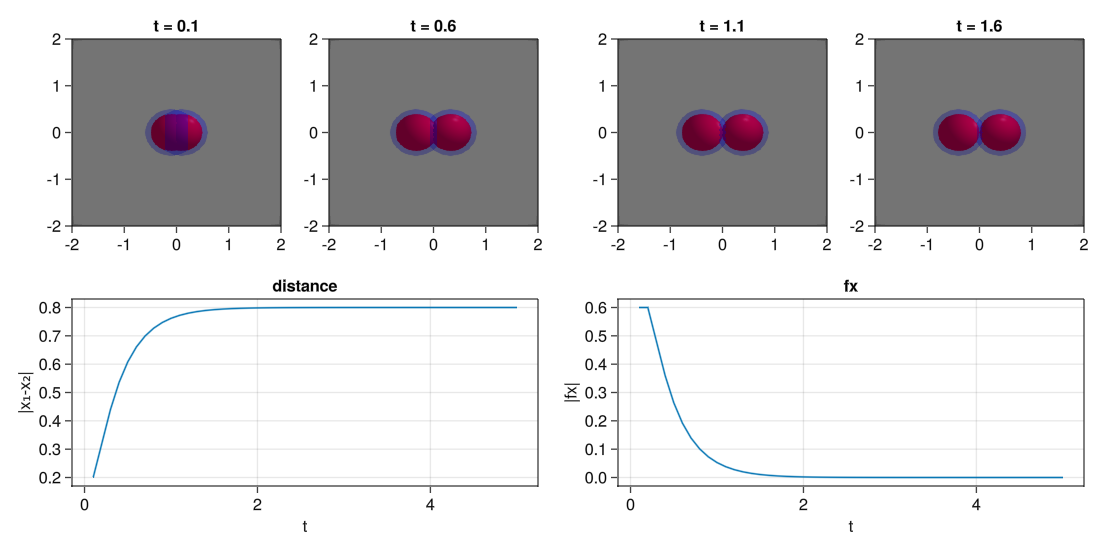

In [6]:
#Make the plot
fig = Figure(resolution=(1100,550))

#Plot the spheres at different times
for (j,i) in enumerate(1:5:20) #Step times
    #Create axis
    ax = Axis(fig[1,j],title="t = $(round(d[:t][i],digits=2))")
    #Add a simulation box rectangle in the background
    mesh!(ax, [simBox[1,1] simBox[2,1];simBox[1,1] simBox[2,2];simBox[1,2] simBox[2,2];simBox[1,2] simBox[2,1]], [1 2 4; 2 3 4], color=:lightgrey)
    #Add spheres with attraction radius    
    meshscatter!(ax,d[:x][i],d[:y][i],markersize=com[:rAtr][1]/2,color=(:blue,.3),transparency=true)
    #Add spheres with attraction radius
    meshscatter!(ax,d[:x][i],d[:y][i],markersize=com[:rRep][1]/2,color=:red)
    #Define the limits
    xlims!(ax,-2,2)
    ylims!(ax,-2,2)
end

#Plot position over time of one of the particles
ax = Axis(fig[2,1:2],title="distance",xlabel="t",ylabel="|x₁-x₂|")
lines!(d[:t],[abs(j-i) for (i,j) in d[:x]])

#Plot forces over time of one of the particles
ax = Axis(fig[2,3:4],title="fx",xlabel="t",ylabel="|fx|")
lines!(d[:t],[abs(i) for (i,j) in d[:fx]])

#Show the plots
display(fig)

### Test repulsion from boundaries

Now that we have shown the process, we do the same for the boundaries.

In [7]:
simBox = [-2. 2; -2 2]
#Initialize community
com = Community(model,
        N=1,
        dt=.1,
        simBox = simBox,
        );

#Setup user paramaters
com.rRep=.8
com.fRep=1
com.rAtr=1.
com.fAtr=1.
com.x=[0]
com.y=[-2.5];

In [8]:
#Evolve
evolve!(com,steps=15)

In [9]:
#Get parameters
d = getParameter(com,[:t,:x,:y,:fx,:fy])

Dict{Symbol, Vector} with 5 entries:
  :fy => [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0],…
  :y  => [[-2.5], [-2.4], [-2.3], [-2.2], [-2.1], [-2.0], [-1.9], [-1.8], [-1.7…
  :fx => [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0],…
  :t  => [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4,…
  :x  => [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0],…

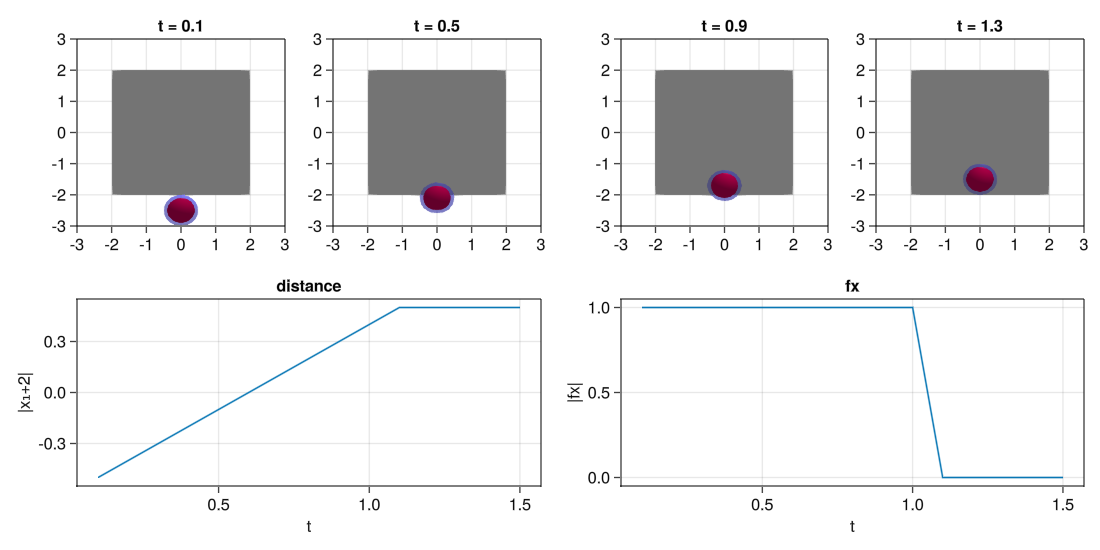

In [10]:
#Plot
fig = Figure(resolution=(1100,550))

#Plot visually the results
for (j,i) in enumerate(1:4:13)
    ax = Axis(fig[1,j],title="t = $(round(d[:t][i],digits=2))")
    mesh!(ax, [simBox[1,1] simBox[2,1];simBox[1,1] simBox[2,2];simBox[1,2] simBox[2,2];simBox[1,2] simBox[2,1]], [1 2 4; 2 3 4], color=:lightgrey)
    meshscatter!(ax,d[:x][i],d[:y][i],markersize=com[:rAtr][1]/2,color=(:blue,.3),transparency=true)
    meshscatter!(ax,d[:x][i],d[:y][i],markersize=com[:rRep][1]/2,color=:red)
    xlims!(ax,-3,3)
    ylims!(ax,-3,3)
end

#Plot position in i
ax = Axis(fig[2,1:2],title="distance",xlabel="t",ylabel="|x₁+2|")
lines!(d[:t],[i+2 for (i,) in d[:y]])

#Plot forces in i
ax = Axis(fig[2,3:4],title="fx",xlabel="t",ylabel="|fx|")
lines!(d[:t],[abs(i) for (i,) in d[:fy]])

display(fig)

# Constructing over a predefined model

Now that we know that everything works for the model, we could start scaling it to many particles. But before we do that, we would like to add one more property to it as we would like to study the behavior of the particles as we cool down the movement. 

For that, we want to make a new model that have exactly the same behaviour as before but in addition we want that the model parameter `D` that controld the diffusion strength is lowered down slowly.

We could rewrite all the model again from scratch, but in this case that is not necessary. We can define a new model that uses as a base the previous one and add the additional property.

Let's define the cooling down of the model with an exponential decay:

$$dD = -\alpha_TDdt$$

In [11]:
model2 = ABM(2,

    #Import the previous model
    baseModelInit = [model],

    #Add an additional model parameter that defines the speed of the diffusion parameter decay
    model = Dict(
        :αT => Float64
    ),

    #Add a ODE to describe the difussion
    modelODE = quote
        dt(D) = -αT*D
    end,

    agentAlg = CBMIntegrators.EM(),
    modelAlg = DifferentialEquations.Euler(),
    neighborsAlg = CBMNeighbors.CellLinked(cellEdge=2),
);

### Evolve the model an check the behaviour

We can define now a now Commmunity and see the evolution in time. We can check that as the diffusion constant is reduced the particles start to aggregate as the adhesion forces dominate the behaviour over the active term.

In [12]:
simBox = [-10. 10; -10 10]
N = 100
com = Community(model2,
        N=N,
        dt=0.1,
        simBox = simBox,
        )

com.rRep=.8
com.fRep=1
com.rAtr=1.
com.fAtr=1.
com.αT=.001 
com.x = 20 .*rand(N) .-10
com.y = 20 .*rand(N) .-10
com.D=.15

0.15

In [13]:
evolve!(com,steps=8000,saveEach=1)

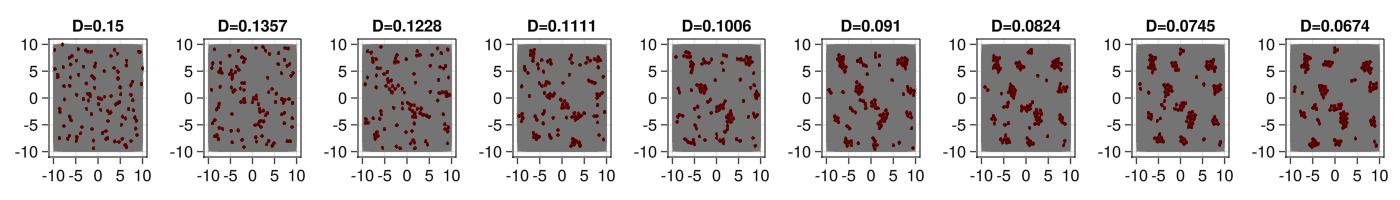

In [14]:
d = getParameter(com,[:x,:y])

fig = Figure(resolution=(1400,200))

for (pos,i) in enumerate(1:999:8000)
    ax = Axis(fig[1,pos],title="D=$(round(com[i].D[1],digits=4))")
    mesh!(ax, [simBox[1,1] simBox[2,1];simBox[1,1] simBox[2,2];simBox[1,2] simBox[2,2];simBox[1,2] simBox[2,1]], [1 2 4; 2 3 4], color=:lightgrey)
    meshscatter!(ax,d[:x][i],d[:y][i],markersize=com[:rAtr][1]/2,color=(:blue,.0),transparency=true)
    meshscatter!(ax,d[:x][i],d[:y][i],markersize=com[:rRep][1]/2,
                color=[com[i].D[1] for i in 1:100],
                colorrange=(0.,0.15),
                colormap=:reds
                )
    xlims!(ax,(simBox[1,:].+[-1,1])...)
    ylims!(ax,(simBox[2,:].+[-1,1])...)
    # lines!(ax,[i[1] for i in d[:x]],[i[1] for i in d[:y]])
end

# save("agg.png",fig)

display(fig)

## Neighbors computational dependence

It may be tempting to run simulations with a large number of particles. However, as we increase the number of particles, the computational time increases quadratically with the system size. 

This is due to the fact that the interaction forces in `@loopOverNeighbors` check all the forces over all neighbors. However, in this model only particles that are close together really interact. 

In CellBasedModels there are implementations of more efficient neighbors searching methods. You can provide them when creating the Community model.

Check how alternative algorithms improve the speeding time.

In [15]:
modelFull = ABM(2, baseModelInit=[model2], agentAlg = CBMIntegrators.EM(), neighborsAlg=CBMNeighbors.Full())
modelVerlet = ABM(2, baseModelInit=[model2], agentAlg = CBMIntegrators.EM(), neighborsAlg=CBMNeighbors.VerletDisplacement(skin=2,nMaxNeighbors=20))
modelCellLinked = ABM(2, baseModelInit=[model2], agentAlg = CBMIntegrators.EM(), neighborsAlg=CBMNeighbors.CellLinked(cellEdge=2))

function initialize(model,N,simBox)
        return Community(model,N=N,
                simBox = simBox,
                
                rRep=.8,
                fRep=1,
                rAtr=1.,
                fAtr=1.,
                D = .5,
                x=rand(N).*(simBox[1,2]-simBox[1,1]).+simBox[1,1],
                y=rand(N).*(simBox[2,2]-simBox[2,1]).+simBox[2,1],
                dt=.1
                );
end;

In [30]:
ρ=.1
S = 1

N = []
tFull = []
tVerlet = []
tCellLinked = []
for S in 1:.5:7
    simBox = S.*[-10. 10; -10 10]
    n = round(Int64,ρ*(simBox[1,2]-simBox[1,1])*(simBox[2,2]-simBox[2,1]))
    push!(N,n)

    com = initialize(modelFull,n,simBox); #Full (default) algorithm
    evolve!(com,steps=10,saveEach=10,saveCurrentState=true)
    t = @elapsed evolve!(com,steps=1000,saveEach=10,saveCurrentState=true)
    push!(tFull,t)

    com2 = initialize(modelVerlet,n,simBox); #Verlet list algorithm
    evolve!(com2,steps=10,saveEach=10,saveCurrentState=true)
    t = @elapsed evolve!(com2,steps=1000,saveEach=10,saveCurrentState=true)
    push!(tVerlet,t)

    com3 = initialize(modelCellLinked,n,simBox); #Cell linked algorithm
    evolve!(com3,steps=10,saveEach=10,saveCurrentState=true)
    t = @elapsed evolve!(com3,steps=1000,saveEach=10,saveCurrentState=true)
    push!(tCellLinked,t)
end

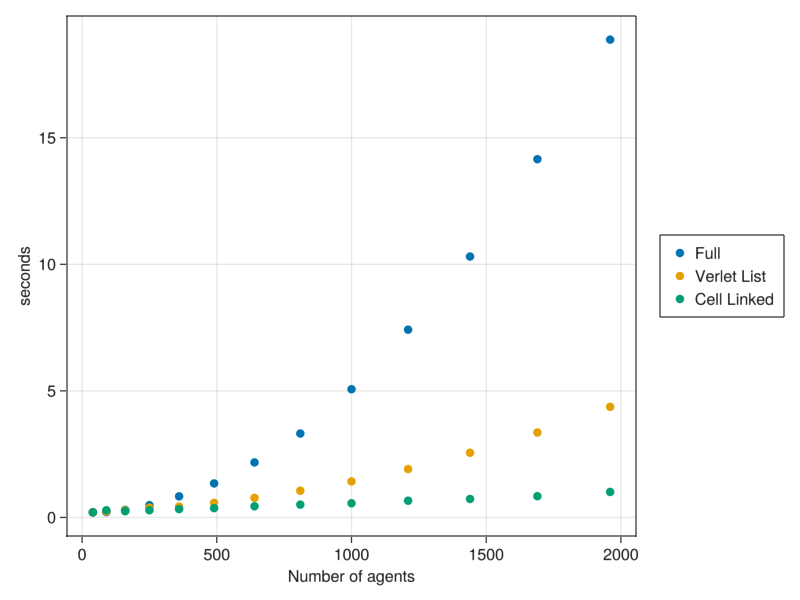

In [31]:
fig = Figure(resolution=(800,600))
ax = Axis(fig[1,1],xlabel="Number of agents",ylabel="seconds")

l1 = scatter!(ax,Float64.(N),Float64.(tFull))
l2 = scatter!(ax,Float64.(N),Float64.(tVerlet))
l3 = scatter!(ax,Float64.(N),Float64.(tCellLinked))
Legend(fig[1,2],[l1,l2,l3],["Full","Verlet List","Cell Linked"])

display(fig)